## Example: an inventory model
This an exmple of an inventory model in *Adjustable robust solutions of uncertain linear programs* . The derivation is omitted here and the Python implementation is presented directly, see the references for details

### Parameters

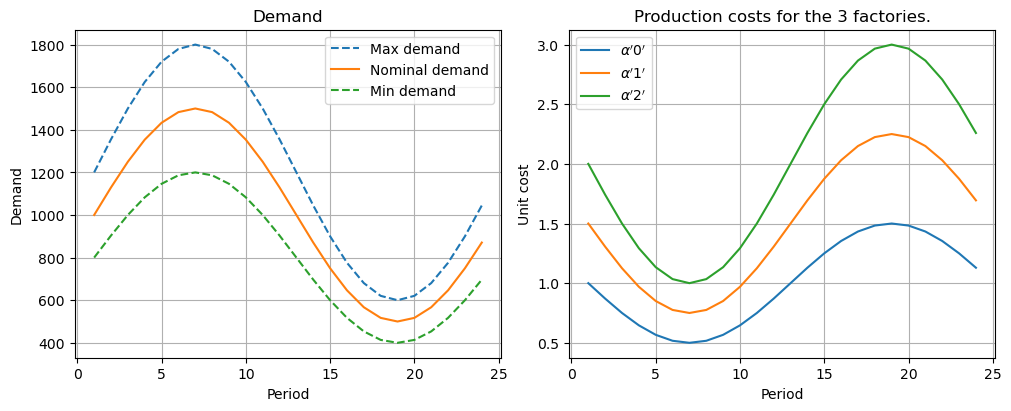

In [345]:
import numpy as np
import matplotlib.pyplot as plt

I = 3 # factories
T = 24 # 24 periods
I_set = np.arange(1,I+1)
T_set = np.arange(1,T+1)
theta = 0.2 # uncertainty level

fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True) 
d_nominal = 1000 * (1 + 0.5 * np.sin(np.pi * (np.arange(1, T+1) - 1) / 12)) # The nominal demand
d_max = (1 + theta) * d_nominal
d_min = (1 - theta) * d_nominal

alpha = [1, 1.5, 2]
c = np.array([[None]* T]*I)
for i, alpha_i in zip(range(I), alpha):
    c[i, :] = alpha_i * (1 - 0.5 * np.sin(np.pi * (np.arange(1, T+1) - 1) / 12)) # The production cost
for i in range(I):
    ax[1].plot(T_set, c[i,:],label = r'$\alpha%r$' %str(i))

ax[0].plot(T_set, d_max,'--', label = "Max demand")
ax[0].plot(T_set, d_nominal,'-', label = "Nominal demand")
ax[0].plot(T_set, d_min,'--',label = "Min demand")
ax[0].set_title('Demand')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Demand')
ax[0].grid(True)
ax[0].legend();
ax[1].set_title('Production costs for the 3 factories.')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Unit cost')
ax[1].grid(True)
ax[1].legend();

### On-line information basis

In [326]:
P = 567
Q = 13600
V_min = 500
V_max = 2000
v_1 = 500
r_pir = np.arange(1,T+1)
t_pir = np.arange(1,T+1)

In [327]:
import gurobipy as gp
from gurobipy import GRB


m = gp.Model("AARC(38)")

# decision variables
pi_0 = m.addVars(I_set, T_set, lb=-GRB.INFINITY, name = "pi_0")
pi_r = m.addVars(r_pir, I_set, t_pir, lb=-GRB.INFINITY, name = "pi_r")
alpha = m.addVars(r_pir, lb=-GRB.INFINITY, name = "alpha")
delta = m.addVars(I_set, r_pir, lb=-GRB.INFINITY, name = "delta")
xi = m.addVars(r_pir, t_pir, lb=-GRB.INFINITY, name = "xi")
F = m.addVar(lb=-GRB.INFINITY, name = "F")
gamma = m.addVars(r_pir, I_set, t_pir, name = "gamma")
beta = m.addVars(r_pir, name = "beta")
zeta = m.addVars(I_set, r_pir, name = "zeta")
eta = m.addVars(r_pir, t_pir, name = "eta")
m.update()

m.setObjective(F, GRB.MINIMIZE)

#constraint 39-1
m.addConstrs(-beta[r] <= alpha[r] for r in r_pir)
m.addConstrs(alpha[r] <= beta[r] for r in r_pir)
for r in r_pir:
    m.addConstr(gp.quicksum(c[i-1,t-1] * pi_r[r,i,t] for t in np.arange(r,T+1) for i in I_set) == alpha[r])
m.addConstr(gp.quicksum(c[i-1,t-1] * pi_0[i,t] for i in I_set for t in T_set) \
            + gp.quicksum(alpha[r] * d_nominal[r-1] for r in r_pir)\
            + theta * gp.quicksum(beta[r] * d_nominal[r-1] for r in r_pir)
            <= F)

#constraint 39-2
for i in I_set:
    for t in t_pir:
        for r in np.arange(1,t+1):
            m.addConstr(-gamma[r,i,t] <= pi_r[r,i,t])
            m.addConstr( pi_r[r,i,t] <= gamma[r,i,t])
for i in I_set:
    for t in t_pir:
        m.addConstr(pi_0[i,t]\
                     + gp.quicksum(pi_r[r,i,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                     + theta * gp.quicksum(gamma[r,i,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                     <= P)
        m.addConstr(pi_0[i,t]\
                     + gp.quicksum(pi_r[r,i,t]  * d_nominal[r-1] for r in np.arange(1,t+1))\
                     - theta * gp.quicksum(gamma[r,i,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                     >= 0)

#constraint 39-3
m.addConstrs(-zeta[i,r] <= delta[i,r] for i in I_set for r in r_pir)
m.addConstrs(delta[i,r] <= zeta[i,r] for i in I_set for r in r_pir)
m.addConstrs(gp.quicksum(pi_r[r,i,t] for t in np.arange(r,T+1)) == delta[i,r] for i in I_set for r in r_pir)
m.addConstrs(gp.quicksum(pi_0[i,t] for t in T_set) \
             + gp.quicksum(delta[i,r] * d_nominal[r-1] for r in r_pir)\
             + theta * gp.quicksum(zeta[i,r] * d_nominal[r-1] for r in r_pir)\
              <= Q for i in I_set)

#constraint 39-4
for t in t_pir:
    for r in np.arange(1,t+1):
        m.addConstr(-eta[r,t] <= xi[r,t])
        m.addConstr( xi[r,t] <= eta[r,t])
        m.addConstr(gp.quicksum(pi_r[r,i,s] for s in np.arange(r,t+1) for i in I_set) - xi[r,t] == 1)
m.addConstr(gp.quicksum(pi_0[i,1] for i in I_set) <= V_max - v_1)
m.addConstr(gp.quicksum(pi_0[i,1] for i in I_set) >= v_1 - V_min)
for t in t_pir:
    m.addConstr(gp.quicksum(pi_0[i,s] for s in np.arange(1,t+1) for i in I_set)\
                 + gp.quicksum(xi[r,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                 + theta * gp.quicksum(eta[r,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                 <= V_max - v_1)
    m.addConstr(gp.quicksum(pi_0[i,s] for s in np.arange(1,t+1) for i in I_set)\
                 + gp.quicksum(xi[r,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                 - theta * gp.quicksum(eta[r,t] * d_nominal[r-1] for r in np.arange(1,t+1))\
                 >= v_1 - V_min)

m.optimize()
print('Objective: {:.3f}'.format(m.Objval))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3186 rows, 4873 columns and 22267 nonzeros
Model fingerprint: 0x77496314
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 51 rows and 2258 columns
Presolve time: 0.01s
Presolved: 3135 rows, 2616 columns, 22342 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    4477    3.2393890e+04   0.000000e+00   0.000000e+00      0s

Solved in 4477 iterations and 0.25 seconds (0.34 work units)
Optimal objective  3.239389012e+04
Objective: 32393.890


### Standard information basis

In [328]:
P = 567
Q = 13600
V_min = 500
V_max = 2000
v_1 = 500
r_pir = np.arange(1,T)
t_pir = np.arange(2,T+1)

In [329]:
import gurobipy as gp
from gurobipy import GRB


m = gp.Model("AARC(38)")

# decision variables
pi_0 = m.addVars(I_set, T_set, lb=-GRB.INFINITY, name = "pi_0")
pi_r = m.addVars(r_pir, I_set, t_pir, lb=-GRB.INFINITY, name = "pi_r")
alpha = m.addVars(r_pir, lb=-GRB.INFINITY, name = "alpha")
delta = m.addVars(I_set, r_pir, lb=-GRB.INFINITY, name = "delta")
xi = m.addVars(r_pir, t_pir, lb=-GRB.INFINITY, name = "xi")
F = m.addVar(lb=-GRB.INFINITY, name = "F")
gamma = m.addVars(r_pir, I_set, t_pir, name = "gamma")
beta = m.addVars(r_pir, name = "beta")
zeta = m.addVars(I_set, r_pir, name = "zeta")
eta = m.addVars(r_pir, t_pir, name = "eta")
m.update()

m.setObjective(F, GRB.MINIMIZE)

#constraint 39-1
m.addConstrs(-beta[r] <= alpha[r] for r in r_pir)
m.addConstrs(alpha[r] <= beta[r] for r in r_pir)
for r in r_pir:
    m.addConstr(gp.quicksum(c[i-1,t-1] * pi_r[r,i,t] for t in np.arange(r+1,T+1) for i in I_set) == alpha[r])
m.addConstr(gp.quicksum(c[i-1,t-1] * pi_0[i,t] for i in I_set for t in T_set) \
            + gp.quicksum(alpha[r] * d_nominal[r-1] for r in r_pir)\
            + theta * gp.quicksum(beta[r] * d_nominal[r-1] for r in r_pir)
            <= F)

#constraint 39-2
for i in I_set:
    for t in t_pir:
        for r in np.arange(1,t):
            m.addConstr(-gamma[r,i,t] <= pi_r[r,i,t])
            m.addConstr( pi_r[r,i,t] <= gamma[r,i,t])
m.addConstrs(pi_0[i,1] <= P for i in I_set)
m.addConstrs(pi_0[i,1] >= 0 for i in I_set)
for i in I_set:
    for t in t_pir:
        m.addConstr(pi_0[i,t]\
                     + gp.quicksum(pi_r[r,i,t] * d_nominal[r-1] for r in np.arange(1,t))\
                     + theta * gp.quicksum(gamma[r,i,t] * d_nominal[r-1] for r in np.arange(1,t))\
                     <= P)
        m.addConstr(pi_0[i,t]\
                     + gp.quicksum(pi_r[r,i,t]  * d_nominal[r-1] for r in np.arange(1,t))\
                     - theta * gp.quicksum(gamma[r,i,t] * d_nominal[r-1] for r in np.arange(1,t))\
                     >= 0)

#constraint 39-3
m.addConstrs(-zeta[i,r] <= delta[i,r] for i in I_set for r in r_pir)
m.addConstrs(delta[i,r] <= zeta[i,r] for i in I_set for r in r_pir)
m.addConstrs(gp.quicksum(pi_r[r,i,t] for t in T_set[r:]) == delta[i,r] for i in I_set for r in r_pir)
m.addConstrs(gp.quicksum(pi_0[i,t] for t in T_set) \
             + gp.quicksum(delta[i,r] * d_nominal[r-1] for r in r_pir)\
             + theta * gp.quicksum(zeta[i,r] * d_nominal[r-1] for r in r_pir)\
              <= Q for i in I_set)

#constraint 39-4
for t in t_pir:
    for r in np.arange(1,t):
        m.addConstr(-eta[r,t] <= xi[r,t])
        m.addConstr( xi[r,t] <= eta[r,t])
        m.addConstr(gp.quicksum(pi_r[r,i,s] for s in np.arange(r+1,t+1) for i in I_set) - xi[r,t] == 1)
m.addConstr(gp.quicksum(pi_0[i,1] for i in I_set) <= V_max - v_1)
m.addConstr(gp.quicksum(pi_0[i,1] for i in I_set) >= v_1 - V_min)
for t in t_pir:
    m.addConstr(gp.quicksum(pi_0[i,s] for s in np.arange(1,t+1) for i in I_set)\
                 + gp.quicksum(xi[r,t] * d_nominal[r-1] for r in np.arange(1,t))\
                 + theta * gp.quicksum(eta[r,t] * d_nominal[r-1] for r in np.arange(1,t))\
                 <= V_max - v_1)
    m.addConstr(gp.quicksum(pi_0[i,s] for s in np.arange(1,t+1) for i in I_set)\
                 + gp.quicksum(xi[r,t] * d_nominal[r-1] for r in np.arange(1,t))\
                 - theta * gp.quicksum(eta[r,t] * d_nominal[r-1] for r in np.arange(1,t))\
                 >= v_1 - V_min)

#m.write("AARC.lp")
m.optimize()
#m.write("AARC.sol")
print('Objective: {:.3f}'.format(m.Objval))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2956 rows, 4489 columns and 20397 nonzeros
Model fingerprint: 0x342e29cf
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 56 rows and 2073 columns
Presolve time: 0.02s
Presolved: 2900 rows, 2416 columns, 20463 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    4272    3.0600654e+04   0.000000e+00   0.000000e+00      0s

Solved in 4272 iterations and 0.25 seconds (0.32 work units)
Optimal objective  3.060065435e+04
Objective: 30600.654


### Directly solved by Rsome

In [338]:
from rsome import ro
import numpy as np

T = 24
t = np.arange(1, T+1)
d0 = 1000 * (1 + 0.5*np.sin(np.pi*(t-1)/12))
alpha = np.array([1, 1.5, 2]).reshape((3, 1))
c = alpha * (1 - 0.5*np.sin(np.pi*(t-1)/12))

P = 567
Q = 13600
vmin = 500
vmax = 2000
v = 500
theta = 0.2

In [341]:
model = ro.Model()

d = model.rvar(T)
uset = (d >= (1-theta)*d0, d <= (1+theta)*d0)

p = model.ldr((3, T))              # define p as affine decision rule
for t in range(1, T):
    p[:, t].adapt(d[:t])           # adaptation of the decision rule

model.minmax((c*p).sum(), uset)    # worst-case objective
model.st(0 <= p, p <= P)
model.st(p.sum(axis=1) <= Q)
for t in range(T):
    model.st(v + p[:, :t+1].sum() - d[:t+1].sum() >= vmin)
    model.st(v + p[:, :t+1].sum() - d[:t+1].sum() <= vmax)

model.solve()
model.do_math().to_lp('model')
print('Objective: {:.3f}'.format(model.get()))

Being solved by the default LP solver...
Solution status: 0
Running time: 1.6235s
Objective: 32393.890


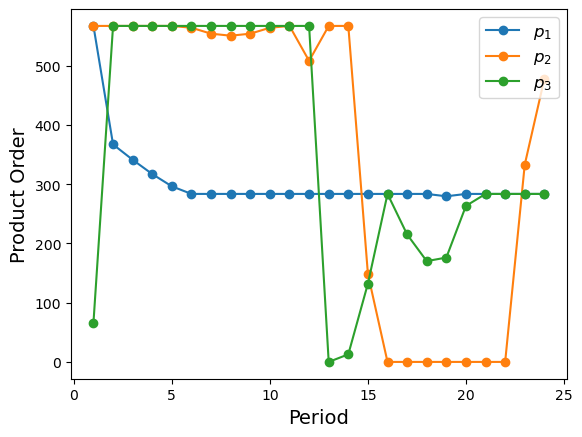

In [342]:
p_nomial = p(d.assign(d0))
plt.plot(np.arange(1, T+1), p_nomial.T, 
         marker='o', label=[r'$p_1$', r'$p_2$', r'$p_3$'])
plt.legend(fontsize=12)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Product Order', fontsize=14)
plt.show()

### Reference
- Ben-Tal A, Goryashko A, Guslitzer E, et al. Adjustable robust solutions of uncertain linear programs[J]. Mathematical programming, 2004, 99(2): 351-376.
- https://xiongpengnus.github.io/rsome/example_ro_inv
- https://zhuanlan.zhihu.com/p/621489179